In [33]:
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [34]:
class UnlimitedDataWorks:

    def __init__(self, deg):
        self.exp = []
        for i in range(deg+1):
            for j in range(deg+1):
                if i+j <= deg:
                    self.exp.append((i, j))

    def train_test_split(self, dataframe):
        self.data = pd.DataFrame([])
        self.count = -1
        for (a, b) in self.exp:
            self.count += 1
            res = ((dataframe["lat"] ** b) * (dataframe["lon"] ** a))
            self.data.insert(self.count, "col" + str(a) + str(b), res, True)

        self.count += 1
        normalize = lambda x: ((x - x.min()) / (x.max() - x.min()))
        dataframe = normalize(dataframe)
        self.data = normalize(self.data)
        self.data["col00"] = [1.0]*len(self.data)
        
        # generate a 70-20-10 split on the data:
        X = self.data[:304113]
        Y = dataframe["alt"][:304113]
        xval = self.data[304113:391088]
        yval = dataframe["alt"][304113:391088]
        x = self.data[391088:]
        y = dataframe["alt"][391088:]   
        return (X, Y, xval, yval, x, y)

In [35]:
class RegressionModel:

    def __init__(self, N, X, Y, x, y, xval, yval):
        """
        X :: training data                  (304113 x 3)
        x :: testing data                   (43786 x 3)
        Y :: training target values         (304113 x 1)
        y :: testing target values          (43786 x 1)
        xval :: validation data             (86975 x 3)
        yval :: validation training data    (86975 X 1)
        """
        self.N = N
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.x = np.array(x)
        self.y = np.array(y)
        self.xval = np.array(xval)
        self.yval = np.array(yval)
        
        self.tmp1 = X["col01"]
        self.tmp2 = X["col10"]
    
    def plotter_3D(self, weights):
        fig = plt.figure()
        pred = (self.X @ weights)
        ax = fig.add_subplot(projection="3d")
        ax.scatter(self.tmp1, self.tmp2, pred,
                   c=pred, cmap="viridis")
        ax.scatter(self.tmp1, self.tmp2, self.Y,
                   c=self.Y, cmap="plasma")

        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_zlabel("Z-axis")
        plt.show()
        
    def score(self, weights):
        """
        the following method helps us find the
        R2 (R-squared) error of a given training data
        wrt the generated weights
        """
        ss_tot = sum(np.square(np.mean(self.y) - self.y))
        ss_res = sum(np.square((self.x @ weights) - self.y))
        rmse = sqrt(ss_res/len(self.x))
        r2 = (1-(ss_res / ss_tot))
        return [r2*100, rmse]

    def gradient_descent(self):
        """
        train till error is almost constant
        """
        lr = 8.5e-7
        prev_err, count = 1e10, 0
        W = np.random.randn(self.N)
        while count <= int(2e4):
            diff = ((self.X @ W) - self.Y)
            err = 0.5 * (diff @ diff)
            grad = (self.X.T @ diff)
            if count % 500 == 0:
                print("epoch =", count, "| err_diff =", prev_err-err)
                print("error = ", err, "||", W)
                print("score =", self.score(W), end="\n\n")
            W -= lr * grad
            if abs(prev_err-err) <= 0.05:
                break
            prev_err = err
            count += 1
        print(count, err)
        print(W, self.score(W), end="\n\n")
        self.plotter_3D(W)
        
    def gradient_descent_L1_reg(self):
        """
        attempts a L1 regularization on the data
        considering 10% of training data as validation data
        """
        W_fin = np.array([])
        lr, l1_fin = 8e-7, 0
        MVLE = 1e10
        L1_vals = np.linspace(0.0, 1.0, 11)
        sgn = lambda x: (x / abs(x))
        for l1 in L1_vals:
            prev_err, count = 1e10, 0
            W = np.random.randn(self.N)
            for _ in range(50001):
                diff = ((self.X @ W) - self.Y)
                err = 0.5 * ((diff @ diff) + l1*sum([abs(w) for w in W]))
                if count % 500 == 0:
                    print("L1 hyperparamter =", l1, end=", ")
                    print("epoch =", count, "| err_diff =", prev_err-err)
                    print("error = ", err, "||", W)
                    print("score =", self.score(W), end="\n\n")
                sgn_w = np.array([sgn(w) for w in W])
                W -= lr * ((self.X.T @ diff) + 0.5*l1*sgn_w)
                if abs(prev_err-err) <= 0.01:
                    break
                prev_err = err
                count += 1
            VLD = ((self.xval @ W) - self.yval)
            VLE = 0.5 * ((VLD.T @ VLD) + l1*sum([abs(w) for w in W]))
            if VLE < MVLE:
                W_fin = W
                l1_fin = l1
                MVLE = VLE
        print(MVLE, l1_fin, W_fin)

    def gradient_descent_L2_reg(self):
        """
        attempts a L2 regularization on the data
        considering 10% of training data as validation data
        """
        W_fin = np.array([])
        lr, l2_fin = 5e-7, 0
        MVLE = 1e10
        L2_vals = np.linspace(0.0, 1.0, 11)
        for l2 in L2_vals:
            prev_err, count = 1e10, 0
            W = np.random.randn(self.N)
            for _ in range(50001):
                diff = ((self.X @ W) - self.Y)
                err = 0.5 * ((diff @ diff) + l2*sum([w*w for w in W]))
                if count % 500 == 0:
                    print("L2 hyperparamter =", l2, end=", ")
                    print("epoch =", count, "| err_diff =", prev_err-err)
                    print("error = ", err, "||", W)
                    print("score =", self.score(W), end="\n\n")
                W -= lr * ((self.X.T @ diff) + l2*W)
                if abs(prev_err-err) <= 0.01:
                    break
                prev_err = err
                count += 1
            VLD = ((self.xval @ W) - self.yval)
            VLE = 0.5 * ((VLD.T @ VLD) + l2 * (W.T @ W))
            if VLE < MVLE:
                W_fin = W
                l2_fin = l2
                MVLE = VLE
        print(MVLE, l2_fin, W_fin)

    def fit(self):
        """
        solves for optimal weights using system of
        N linear equations; AW = B, hence, W = inv(A)*B
        """
        B = self.X.T @ self.Y
        A = self.X.T @ self.X
        W = (np.linalg.inv(A)) @ B
        print(W, self.score(W))
        tmp = ((self.X @ W) - self.Y)
        print("train_error =", 0.5 * (tmp @ tmp))
        self.plotter_3D(W)

Enter the Degree of the Polynomial:6
[ 4.99588776e+01 -3.20315369e+06  1.71633377e+07 -3.55643620e+07
  3.60196974e+07 -1.88772098e+07  4.00890569e+06 -5.46200062e+05
 -7.95477250e+05  5.54076125e+05  6.32978250e+05  8.55372812e+05
 -2.03230094e+05  1.43713462e+06  8.50947125e+05 -2.12036375e+05
 -6.70839250e+05 -3.79513172e+05 -1.08419981e+06 -1.08523750e+05
 -8.98774250e+05  5.29703062e+05  3.14069219e+04 -3.95298906e+04
  3.24681500e+05  1.54457875e+05  1.79218125e+04 -6.08500000e+02] [-4910.090129520549, 0.8264785604953621]
train_error = 70524.40000501776


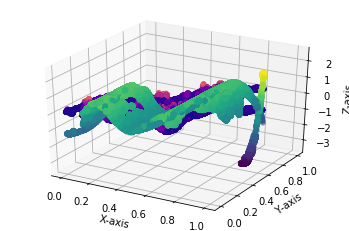

epoch = 0 | err_diff = 9971130312.009026
error =  28869687.99097436 || [  3.74478648  12.08444677 -10.23955857  -3.91420819  11.79261448
  -2.10316986 -14.47781119  -7.36004708   2.67802516  -3.37202386
  -7.83681777  -3.9766343   11.32300393 -19.97858798   2.04977909
   6.87782154 -10.48044273 -17.67311593   3.24597117  -2.11530996
 -16.98012279  -0.3201685  -15.87007829  13.5409925   18.67443933
   3.48944602  15.45887108  -7.18958592]
score = [-1658851.8777487804, 15.039234007800445]

epoch = 500 | err_diff = 52.55310138780624
error =  50345.472554200795 || [ -1.51990052  10.28535288 -11.20982023  -4.07859906  12.39979285
  -0.7684124  -12.46717468  -1.25828748   1.39905901  -4.05913489
  -7.80025785  -3.21118126  12.78914575 -13.87272386   1.25515974
   6.46443301 -10.24714894 -16.75179751   9.35579106  -2.45719308
 -17.12872867   0.10569015  -9.75645147  13.62349543  18.78231859
   9.60673085  15.94024836  -1.06879204]
score = [-2930.5136381145603, 0.6427867917908854]

epoch = 100

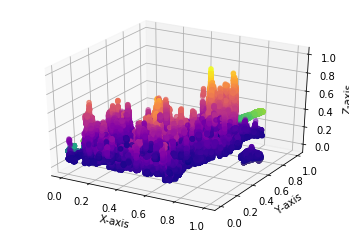

In [36]:
columns = ["junk", "lat", "lon", "alt"]
raw_df = pd.read_csv("3D_spatial_network.txt", sep=',', header=None,
                     names=columns).drop("junk", 1)

deg = input("Enter the Degree of the Polynomial:")
pre_processor = UnlimitedDataWorks(deg=int(deg))
X_train, Y_train, x_val, y_val, x_test, y_test = pre_processor.train_test_split(raw_df)

model = RegressionModel(N=pre_processor.count,
                        X=X_train,
                        Y=Y_train,
                        x=x_test,
                        y=y_test,
                        xval=x_val,
                        yval=y_val)

model.fit()
model.gradient_descent()
# model.gradient_descent_L1_reg()
# model.gradient_descent_L2_reg()